In [3]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib import cm
%matplotlib inline

# Plot Parameters

In [4]:
#parameters
plotdir = "./plots"
font = { 'size'   : 15}
plt.rc('font', **font)
markersize = 80 #12

#markers
colors = ['b','r','g','m','y','c']
styles = ['o','s','v','^','D',">","<","*","h","H","+","1","2","3","4","8","p","d","|","_",".",","]

#styledict
styledict = {"thorsten": {"fontsize_annotation": 10, "roof_color": 'gray', "legend_points_ncol": 2, "frameon": False}, 
             "charlene": {"fontsize_annotation": 15, "roof_color": 'k', "legend_points_ncol": 1, "frameon": True}}

# Plot Code

In [5]:
#plot roofs
def plot_roofs(fig, ax, xlim, ylim, styledict, scaling = 1.):
    #extract general settings
    fontsize_annotation = styledict["fontsize_annotation"] #10
    roof_color = styledict["roof_color"]
    
    #set up roofs
    #mem
    smemroofs = [14*1024, 2996.77, 828.758]
    smem_roof_name = ['L1', 'L2', 'HBM']
    #flops
    scomproofs_fp64 = [7068.86, 3535.79]
    #scomproofs_fp64 = [x*10**-3 for x in scomproofs_fp64]
    scomp_roof_name_fp64 = ['FMA (FP64)', 'No-FMA (FP64)']
    scomproofs_fp32 = [2.*x for x in scomproofs_fp64]
    scomp_roof_name_fp32 = ['FMA (FP32)', 'No-FMA (FP32)']
    scomproofs_fp16 = [125000.0] + [4.*x for x in scomproofs_fp64]
    scomp_roof_name_fp16 = ['Tensor Core (FP16)', 'FMA (FP16)', 'No-FMA (FP16)']
    scalingFactorForRoofs = scaling
    
    #resolution
    #nx = 10000
    xmin = xlim[0]
    xmax = xlim[1]
    ymin = ylim[0]
    ymax = ylim[1]
    nx = 10*xmax
    
    #set limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    #plot roofs:
    dx = (xmax-xmin)/nx
    for idm, smem in enumerate(smemroofs):
        
        #fp32
        for idc, scomp in enumerate(scomproofs_fp32):
            xvals = np.arange(xmin, xmax, dx)
            yvals = np.minimum(smem*xvals, np.tile(np.array(scomp),len(xvals)))
            ax.plot(xvals, yvals, c=roof_color, ls='-', lw='2')
            #find elbow
            optimize = minimize(fun=lambda x: np.abs(smem*x-scomp), x0=xmin, tol=1.e-10)
            xelb = optimize["x"][0]
            yelb = min(smem*xelb, scomp)
            if idm==0:
                #plot scomp
                label = scomp_roof_name_fp32[idc] + ': ' + '{0:.1f}'.format(float(scomp*10**-3)/scalingFactorForRoofs) + ' TFLOP/s'
                ax.annotate(label, xy=(xelb,scomp), xytext=(17,5), textcoords="offset points", color=roof_color, horizontalalignment='left', fontsize=fontsize_annotation)
        #fp16
        for idc, scomp in enumerate(scomproofs_fp16):
            xvals = np.arange(xmin, xmax, dx)
            yvals = np.minimum(smem*xvals, np.tile(np.array(scomp),len(xvals)))
            ax.plot(xvals, yvals, c=roof_color, ls='-', lw='2')
            if idm==0:
                #plot scomp
                label = scomp_roof_name_fp16[idc] + ': ' + '{0:.1f}'.format(float(scomp*10**-3)/scalingFactorForRoofs) + ' TFLOP/s'
                ax.annotate(label, xy=(xmax,scomp), xytext=(-5,5), textcoords="offset points", color=roof_color, horizontalalignment='right', fontsize=fontsize_annotation)
        
        #plot mem
        #find intersection
        scomp = scomproofs_fp16[0]
        yis = ymin
        xis = minimize(fun = lambda x: np.abs(min([smem*x,scomp])-yis), x0=xmin, tol=1.e-10)["x"][0]
        #find elbow
        optimize = minimize(fun=lambda x: np.abs(smem*x-scomp), x0=xmin, tol=1.e-10)
        xelb = optimize["x"][0]
        yelb = min(smem*xelb, scomp)
        #angle in plot coord system
        ang = np.rad2deg( np.arctan2(yelb-yis, xelb-xis) )
        #angle in figure coord system
        pts = np.array((xelb, yelb)).reshape((1,2))
        trans_ang = ax.transData.transform_angles(np.array((ang,)), pts)[0]
        #ax.plot(xis, yis, marker="o", ms=10)
        #ax.plot(xelb, yelb, marker="o", ms=10)
        label = smem_roof_name[idm] + ': ' + '{0:.1f}'.format(float(smem)/scalingFactorForRoofs) + ' GB/s'
        ax.annotate(label, xy=(xelb, yelb), xytext=(3,-5), color=roof_color, \
                rotation=trans_ang, rotation_mode='anchor', \
                horizontalalignment='right', \
                verticalalignment='top', \
                textcoords="offset points", \
                fontsize=fontsize_annotation)

In [6]:
#data dependent stuff
def plot_data(file_prefix, plot_label, mem_level, df):
    
    #pick style:
    style = styledict["thorsten"]
    
    #Mixed data
    df_mixed = df[ df["Precision"] == "mixed" ]
    Times_mixed = df_mixed["CUDA Time Avg"].values
    FLOPs_mixed = df_mixed["Performance GFlop/s"].values #list(df_fp16["FP16 Performance GFlop/s"])
    
    if mem_level == "L1":
        AI_mixed = df_mixed["L1 AI"].values
    elif mem_level == "L2":
        AI_mixed = df_mixed["L2 AI"].values
    elif mem_level == "DRAM":
        AI_mixed = df_mixed["DRAM AI"].values
    elif mem_level == "SYSMEM":
        AI_mixed = df_mixed["SYSMEM AI"].values
    
    labels_mixed = ["Mixed Precision"]
    
    #figure stuff
    fig = plt.figure(1,figsize=(10.67,6.6))
    plt.clf()
    ax = fig.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Arithmetic Intensity [FLOP/Byte]')
    ax.set_ylabel('Performance [GFLOP/s]')
    xmin = -2 #np.floor(np.log(min(AI_l1))) #-2
    xmax = 3.2 #np.ceil(np.log(max(AI_dram)))
    ymin = max(min([6500.0*0.5] + [0.5*x for x in FLOPs_mixed]), 500.0) #10./scalingFactorForRoofs #10.0 / scalingFactorForRoofs
    ymax = 125000.0*5.5 #max(FLOPs)*2./scalingFactorForRoofs
    
    #some handles
    marker_handles = []
    
    #plot roofs
    plot_roofs(fig, ax, (10**xmin, 10**xmax), (ymin, ymax), style)
    
    #colormap
    norm = cm.colors.Normalize(vmax=Times_mixed.max(), vmin=Times_mixed.min())
    cmap = cm.cool
    
    ##FP32
    cset = ax.scatter(AI_mixed, FLOPs_mixed, c=Times_mixed, cmap="cool", norm=norm, marker="o", s=markersize, label=labels_mixed[0])
    fig.colorbar(cset, ax=ax)
    
    #save figure
    plt.tight_layout()
    plt.savefig(file_prefix+'.png')
    plt.savefig(file_prefix+'.eps')

# Load Data

In [7]:
datadir = "./"
resultdf = pd.read_csv(os.path.join(datadir,"profile.csv"))

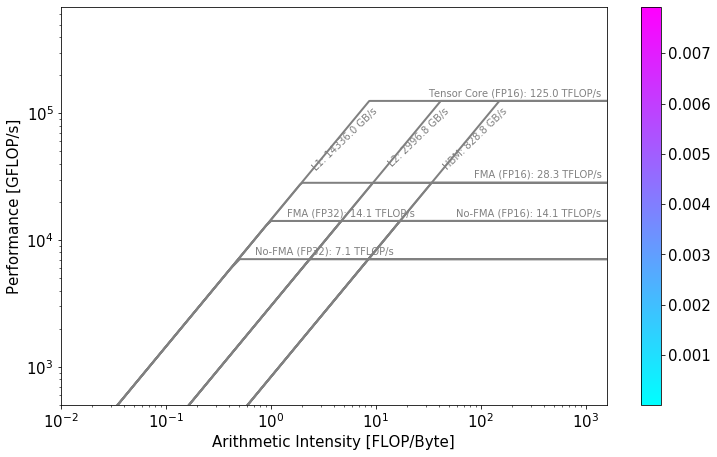

In [10]:
#plot vs batchsize
directory="plots"
try:
    os.stat(directory)
except:
    os.mkdir(directory)

features = list(resultdf[["Pass"]].apply(lambda x: (x["Pass"]), axis=1).unique())

for idx,feature in enumerate(features):
    
    #project the data
    selectdf = resultdf[ (resultdf[ "Pass" ] == feature) ]
    
    #label
    plot_label = 'DeepCAM '+ feature[0]
    plot_file = os.path.join(directory, plot_label.replace(" ","_"))
    #plot_label = None
    for mem in ["L1", "L2", "DRAM", "SYSMEM"]:
        plot_data("deepcam_pytorch_" + feature.lower() + "_roofline_" + mem.lower(), plot_label, mem, selectdf)